In [ ]:
# The van der pol oscillator equation is given by:
# d²x/dt² - μ(1 - x²)dx/dt + x = 0

# The term μ(1 - x²)dx/dt does two things simultaneously:
# when |x| < 1, it adds energy to the system (negative damping),
# and when |x| > 1, it removes energy from the system (positive damping).
# this leads to a state dependent damping effect.

# It is also a relaxation oscillator,
# meaning it exhibits slow and fast dynamics.
# This leads to sharp transitions in the oscillation waveform,

# Limit cycles also appear regardless of the initial conditions,
# making the van der pol oscillator a classic example of self-sustained oscillations.

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [4]:
# Write the van der pol oscillator as a system of first-order ODEs
def vdp_rhs(t, y, mu):
    u, v = y
    du_dt = v
    dv_dt = mu * (1.0 - u**2) * v - u
    return [du_dt, dv_dt]


In [5]:
# Generate training data by solving the van der pol oscillator ODE
def make_data_vdp(
    n_systems=300,      # number of different parameter sets
    num_points=300,     # time points per trajectory
    t_max=20.0
):
    # Initial conditions (wider to capture transient)
    u0_all = np.random.uniform(-3.0, 3.0, size=(n_systems, 1))
    v0_all = np.random.uniform(-3.0, 3.0, size=(n_systems, 1))

    # mu parameter range (moderate to avoid extreme stiffness)
    mu_all = np.random.uniform(0.5, 3.0, size=(n_systems, 1))

    # Common time grid
    t_grid = np.linspace(0.0, t_max, num_points).reshape(-1, 1)

    X_list = []
    y_list = []

    for u0, v0, mu in zip(u0_all, v0_all, mu_all):
        sol = solve_ivp(
            fun=lambda tau, y: vdp_rhs(tau, y, float(mu)),
            t_span=(0.0, float(t_grid[-1, 0])),
            y0=[float(u0), float(v0)],
            t_eval=t_grid.flatten(),
            method="RK45",
            rtol=1e-7,
            atol=1e-7,
        )
        u_traj = sol.y[0].reshape(-1, 1)  # (num_points, 1)

        U0 = np.full_like(t_grid, u0)
        V0 = np.full_like(t_grid, v0)
        MU = np.full_like(t_grid, mu)

        X_traj = np.hstack([U0, V0, MU, t_grid])
        y_traj = u_traj

        X_list.append(X_traj)
        y_list.append(y_traj)

    X = np.vstack(X_list).astype(np.float32)
    y = np.vstack(y_list).astype(np.float32)

    # Scale t to [0, 1] for nicer optimisation (last column)
    X[:, -1] /= t_max

    return X, y, t_max

In [6]:
# Sin activation function
def sin_activation(x):
    return tf.sin(x)

In [7]:
# Calling the data generation function
X, y, T_MAX = make_data_vdp()
print("Van der Pol dataset shapes:", X.shape, y.shape)

# Shuffle
idx = np.random.permutation(len(X))
X, y = X[idx], y[idx]

# Train/val split
split = int(0.8 * len(X))
X_train, y_train = X[:split], y[:split]
X_val,   y_val   = X[split:], y[split:]


/var/folders/db/nfyhgnf50fxd8qjfrpdb671c0000gn/T/ipykernel_81492/2066656220.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y0=[float(u0), float(v0)],
/var/folders/db/nfyhgnf50fxd8qjfrpdb671c0000gn/T/ipykernel_81492/2066656220.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fun=lambda tau, y: vdp_rhs(tau, y, float(mu)),


Van der Pol dataset shapes: (90000, 4) (90000, 1)


In [8]:
# Build the neural network model
model = models.Sequential([
    layers.Input(shape=(4,)),
    layers.Dense(256, activation="tanh"),
    layers.Dense(256, activation=sin_activation),   # useful for periodic limit-cycle behaviour
    layers.Dense(256, activation="tanh"),
    layers.Dense(128, activation="tanh"),
    layers.Dense(1)
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 165,889 (648.00 KB)

 Trainable params: 165,889 (648.00 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Compile the model
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss="mse"
)

In [10]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=512,
    verbose=2
)

Epoch 1/100
141/141 - 2s - 14ms/step - loss: 2.2722 - val_loss: 2.2012
Epoch 2/100
141/141 - 1s - 6ms/step - loss: 2.1176 - val_loss: 1.9300
Epoch 3/100
141/141 - 1s - 5ms/step - loss: 1.7470 - val_loss: 1.5153
Epoch 4/100
141/141 - 1s - 5ms/step - loss: 1.2768 - val_loss: 0.9738
Epoch 5/100
141/141 - 1s - 6ms/step - loss: 0.6780 - val_loss: 0.3902
Epoch 6/100
141/141 - 1s - 5ms/step - loss: 0.2434 - val_loss: 0.2091
Epoch 7/100
141/141 - 1s - 6ms/step - loss: 0.1225 - val_loss: 0.1462
Epoch 8/100
141/141 - 1s - 5ms/step - loss: 0.0884 - val_loss: 0.0752
Epoch 9/100
141/141 - 1s - 6ms/step - loss: 0.0682 - val_loss: 0.0628
Epoch 10/100
141/141 - 1s - 8ms/step - loss: 0.0584 - val_loss: 0.0560
Epoch 11/100
141/141 - 1s - 10ms/step - loss: 0.0494 - val_loss: 0.0421
Epoch 12/100
141/141 - 2s - 15ms/step - loss: 0.0433 - val_loss: 0.0425
Epoch 13/100
141/141 - 1s - 8ms/step - loss: 0.0368 - val_loss: 0.0344
Epoch 14/100
141/141 - 1s - 10ms/step - loss: 0.0388 - val_loss: 0.0366
Epoch 15/10

In [11]:
# Testing helper
def test_vdp_system(u0_test, v0_test, mu_test, title):
    t_max_test = 20.0
    t_grid = np.linspace(0.0, t_max_test, 400).reshape(-1, 1).astype(np.float32)

    # true solution via solve_ivp
    sol = solve_ivp(
        fun=lambda tau, y: vdp_rhs(tau, y, mu_test),
        t_span=(0.0, float(t_grid[-1, 0])),
        y0=[u0_test, v0_test],
        t_eval=t_grid.flatten(),
        method="RK45",
        rtol=1e-7,
        atol=1e-7,
    )
    u_true = sol.y[0].reshape(-1, 1).astype(np.float32)

    # NN input
    t_scaled = t_grid / T_MAX
    X_test = np.hstack([
        np.full_like(t_scaled, u0_test),
        np.full_like(t_scaled, v0_test),
        np.full_like(t_scaled, mu_test),
        t_scaled
    ]).astype(np.float32)

    u_pred = model.predict(X_test)

    # plot
    plt.figure(figsize=(8, 4))
    plt.plot(t_grid, u_true, "k-", label="True (SciPy)")
    plt.plot(t_grid, u_pred, "r--", label="NN")
    plt.xlabel("t")
    plt.ylabel("u(t)")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [12]:
# Test cases

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


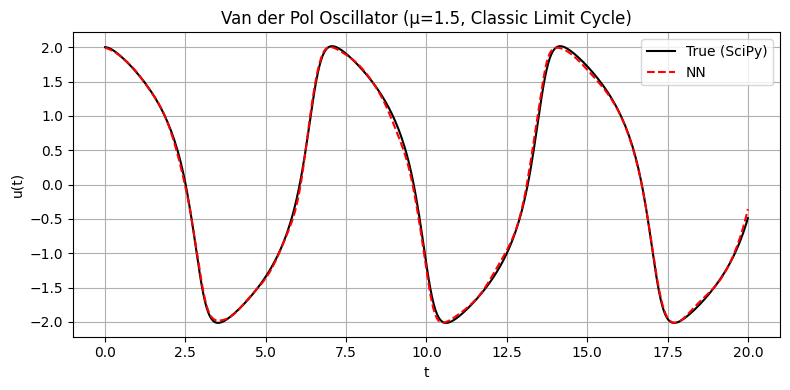

In [13]:
# Moderate mu, classic limit cycle behaviour
test_vdp_system(
    u0_test=2.0,
    v0_test=0.0,
    mu_test=1.5,
    title="Van der Pol Oscillator (μ=1.5, Classic Limit Cycle)"
)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


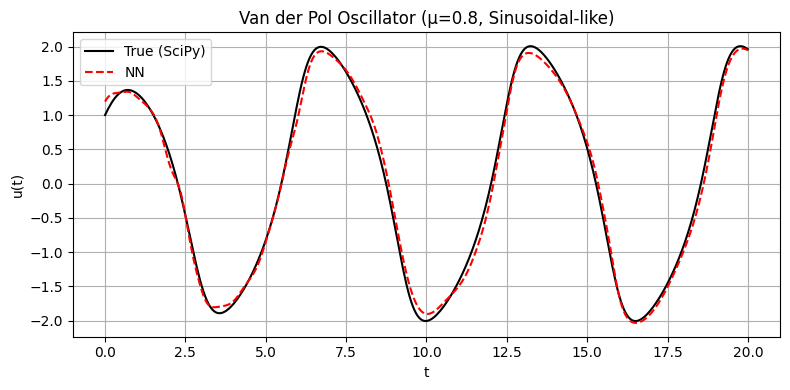

In [14]:
# Smaller mu, more sinusoidal oscillations
test_vdp_system(
    u0_test=1.0,
    v0_test=1.0,
    mu_test=0.8,
    title="Van der Pol Oscillator (μ=0.8, Sinusoidal-like)"
)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


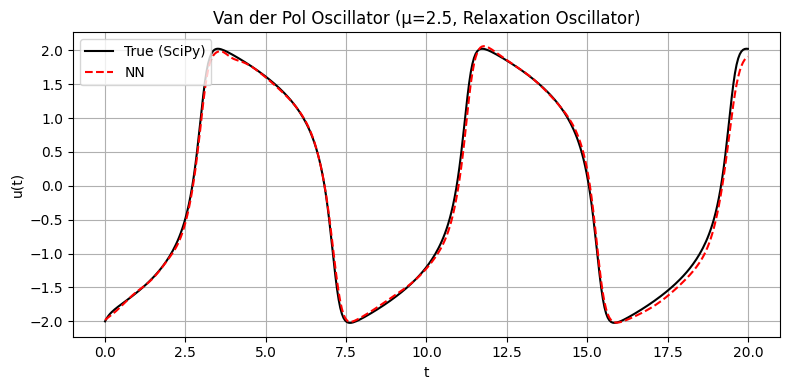

In [15]:
# Larger mu, sharper transitions
test_vdp_system(
    u0_test=-2.0,
    v0_test=1.0,
    mu_test=2.5,
    title="Van der Pol Oscillator (μ=2.5, Relaxation Oscillator)"
)